# Neutral density

This notebook calculates neutral density ($\gamma$) from the algorithm developed by [Jackett and McDougall 1997](https://doi.org/10.1175/1520-0485(1997)027<0237:ANDVFT>2.0.CO;2).

Before using neutral density, be aware that it is a calculation that uses as a reference a climatology from the World Atlas, Levitus 1980. So **it shouldn't be used for simulations or datasets with climates/ocean states different to the 1980s (i.e. future projection simulations)**.

We will use a python wrapper called `pygamma_n`, developed by Eric Firing and Filipe Fernandes (https://currents.soest.hawaii.edu/hgstage/pygamma_n). 

### Things to note, future improvements

 - The `pygamma_n` package was developed to use with oceanographic data, i.e. CTDs. Therefore, applying to 3D, time-varying datasets, is not implemented. We work around this by iterating - this can probably be improved upon.

In [1]:
# Load the relevant libraries
import numpy as np
import xarray as xr
import cf_xarray as cfxr
import gsw
import pygamma_n

# Catalog for browsing experiments
import intake
catalog = intake.cat.access_nri

# Plotting
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmocean

# Others
import dask.distributed as dask
import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
# Initialise a dask client
client = dask.Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 18.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46651,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 18.00 GiB
Comm: tcp://127.0.0.1:41391,Total threads: 1
Dashboard: /proxy/39307/status,Memory: 4.50 GiB
Nanny: tcp://127.0.0.1:40453,


In [5]:
# Define arguments needed to load data from either MOM5 or MOM6
model_args = {"mom5": {"expt": "01deg_jra55v13_ryf9091",
                       "variables":["temp", "salt"],
                       "start_time": "2000-01-01",
                       "end_time": "2001-01-01"},

              "mom6": {"expt": "panant-01-zstar-ACCESSyr2",
                       "variables":["thetao", "so"],
                       "start_time": "2000-01-01",
                       "end_time": "2001-01-01",
                       "frequency": "1 monthly"}
             }

Define the region to work with:

In [16]:
latitude_slice = slice(-70, -60)
longitude_slice = slice(-70, -40)

We will define a function to load the data needed depending on the model selected. Note that from `mom5` simulations we get conervative temperature (`temp`), whereas from `mom6` we get potential temperature (`thetao`). Both models give us practical salinity, called `salt` and `so` for `mom5` and `mom6` respectively. Also, `mom5` gives us temperature in K! Because neutral density calculation takes in situ temperature, we will use `gsw` to obtain it either model output.

In [23]:
def load_temp_salt(model):

    """
    This function loads temperature and salinity variables from the model selected, and does
    the necessary calculations to return in-situ temperature and practical salinity.
    """

    experiment = model_args[model]["expt"]
    start_time = model_args[model]["start_time"]
    end_time = model_args[model]["end_time"]
    if model == 'mom5':
        T = 'temp'
        S = 'salt'
    elif model == 'mom6':
        T = 'thetao'
        S = 'so'

    # Load variables
    data = catalog[model_args[model]["expt"]].search(variable = model_args[model]["variables"], 
                                                     frequency = "1mon").to_dask()
    
    # Ensure we get the time-slice we wanted
    temp = data[T].cf.sel({'time':slice(start_time, end_time)})
    salt = data[S].cf.sel({'time':slice(start_time, end_time)})
    
    # Crop a region (we don't want global/circumpolar data for the sakes of this example)
    temp = temp.cf.sel({'longitude':longitude_slice, 'latitude':latitude_slice})
    salt = salt.cf.sel({'longitude':longitude_slice, 'latitude':latitude_slice})

    # Calculate pressure from the vertical axis and absolute salinity
    pressure = gsw.p_from_z(-salt.cf['vertical'], salt.cf['latitude'].mean())
    absolute_salinity = gsw.SA_from_SP(salt, pressure, salt.cf['longitude'], salt.cf['latitude'])
    
    # Get in-situ temperature
    if model == 'mom5':
        insitu_temp = gsw.t_from_CT(absolute_salinity, temp - 273.15, pressure).rename('temp')
    elif model == 'mom6':
        conservative_temperature = gsw.CT_from_pt(absolute_salinity, temp)
        insitu_temp = gsw.t_from_CT(absolute_salinity, conservative_temperature, pressure).rename('temp')

    return insitu_temp, salt

The `pygamma_n` function to calculate neutral densities takes 2D fields. So for our time-varying, 3D fields we are going to need to iterate twice. We will define a function that calculates $\gamma$ for a certain time step and longitude.

In [21]:
def neutral_density(temp, salt, time_step, longitude):

    """
    This function calculates neutral density (gamma) for a given longitude and time 
    of in-situ temperature and practical salinity datasets.
    """
    
    # Select the longitude and time_step
    temp_i = temp.cf.isel({'longitude':longitude, 'time':time_step})
    salt_i = salt.cf.isel({'longitude':longitude, 'time':time_step})
    pressure_i = gsw.p_from_z(-salt_i.cf['vertical'], salt_i.cf['latitude'])
    latitude_i = temp_i.cf['latitude']
    longitude_i = latitude_i*0 + temp.cf['longitude'][longitude]
    
    gamma, dg_lo, dg_hi = pygamma_n.gamma_n(salt_i.transpose(), temp_i.transpose(), pressure_i.transpose(), 
                                            longitude_i, latitude_i)
    gamma  = gamma.T
    
    return gamma

Now we are ready. First, let's open some data:

In [24]:
t_mom5, s_mom5 = load_temp_salt('mom5')

And load into memory:

In [25]:
t_mom5 = t_mom5.load()
s_mom5 = s_mom5.load()

Create a `nan` array to fill up with output of our `neutral_density()` function:

In [26]:
gamma_mom5 = np.zeros(np.shape(t_mom5))*np.nan

Iterate through time and longitudes to fill in `gamma_mom5`:

In [27]:
%%time
T = len(t_mom5.cf['time'])
X = len(t_mom5.cf['longitude'])

for time_step in range(0,T):
    for longitude in range(0,X):
        gamma_XT = neutral_density(t_mom5, s_mom5, time_step, longitude)
        gamma_mom5[time_step, :, :, longitude] = gamma_XT
    # Print the time_step so the impatients know how much is left to do
    print(np.round(100*(time_step+1)/T, 2), '% done')

8.33 % done
16.67 % done
25.0 % done
33.33 % done
41.67 % done
50.0 % done
58.33 % done
66.67 % done
75.0 % done
83.33 % done
91.67 % done
100.0 % done
CPU times: user 26min 59s, sys: 37.1 s, total: 27min 36s
Wall time: 27min 10s


Make an `xarray.DataArray` complete with dimensions and coordinates, as well as some attributes:

In [28]:
gamma_mom5 = xr.DataArray(gamma_mom5, dims = t_mom5.dims, coords = t_mom5.coords, name = 'gamma')
gamma_mom5.attrs['long_name'] = 'neutral density'
gamma_mom5.attrs['units'] = 'kg/m3'

`pygamma_n.gamman` has a fill value of 0. Let's replace that with nans:

In [29]:
gamma_mom5 = gamma_mom5.where(gamma_mom5 != 0, np.nan)

### Notes on efficiency

As you can see, doing this for just 1 year of monthly data and a very small region is very slow. It could probably be parallelised.

### Doing it `mom6` - won't work until panant is indexed in the catalog

Let's put all of the above steps in one cell and run:

In [30]:
t_mom6, s_mom6 = load_temp_salt('mom6')
t_mom6 = t_mom6.load()
s_mom6 = s_mom6.load()
gamma_mom6 = np.zeros(np.shape(t_mom6))*np.nan

T = len(t_mom6.cf['time'])
X = len(t_mom6.cf['longitude'])

for time_step in range(0,T):
    for longitude in range(0,X):
        gamma_XT = neutral_density(t_mom6, s_mom6, time_step, longitude)
        gamma_mom6[time_step, :, :, longitude] = gamma_XT
    # Print the time_step so the impatients know how much is left to do
    print(100*time_step/T, '% done')

gamma_mom6 = xr.DataArray(gamma_mom6, dims = t_mom6.dims, coords = t_mom6.coords, name = 'gamma')
gamma_mom6.attrs['long_name'] = 'neutral density'
gamma_mom6.attrs['units'] = 'kg/m3'
gamma_mom6 = gamma_mom6.where(gamma_mom6 != 0, np.nan)

KeyError: "key='panant-01-zstar-ACCESSyr2' not found in catalog. You can access the list of valid source keys via the .keys() method."

# Plotting

Let's get the model's land mask to plot the time-mean neutral density at a certain depth.

In [32]:
def get_land_mask(model):
    experiment = model_args[model]["expt"]
    if model == 'mom5':
        bathy_var = 'ht'
    elif model == 'mom6':
        bathy_var = 'deptho'
        
    bathymetry = cc.querying.getvar(experiment, bathy_var, session = session, n = 1)
    bathymetry = bathymetry.cf.sel({'longitude':longitude_slice, 'latitude':latitude_slice})
    
    land_mask = xr.where(np.isnan(bathymetry), 1, np.nan)
    land_mask = land_mask.rename('land_mask')
    
    return land_mask

In [33]:
land_mask_mom5 = get_land_mask('mom5')
land_mask_mom6 = get_land_mask('mom6')

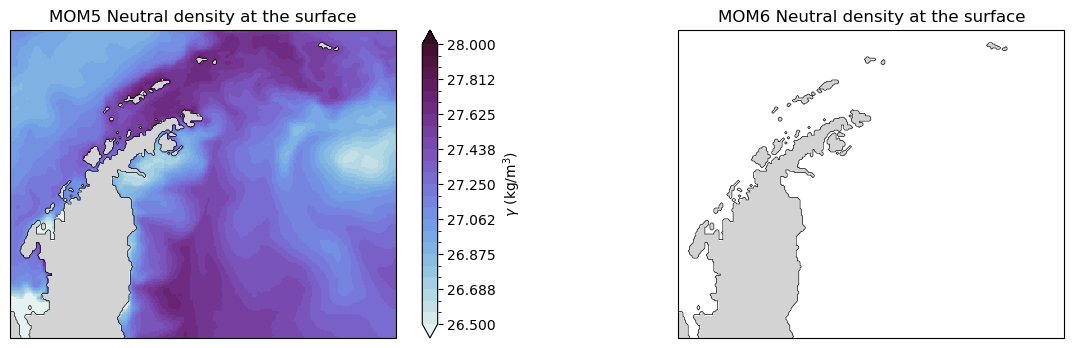

In [41]:
fig = plt.figure(figsize = (15, 4))
axs = [fig.add_subplot(121, projection = ccrs.Mercator(central_longitude = -55)),
       fig.add_subplot(122, projection = ccrs.Mercator(central_longitude = -55))]
# Set the region
for ax in axs:
    ax.set_extent([-70, -40, -70, -60], crs = ccrs.PlateCarree())
# Add model land mask
land_mask_mom5.plot.contourf(ax=axs[0], colors='lightgrey', transform=ccrs.PlateCarree(), add_colorbar=False, zorder=2)
land_mask_mom6.plot.contourf(ax=axs[1], colors='lightgrey', transform=ccrs.PlateCarree(), add_colorbar=False, zorder=2)
# Add model coastline
land_mask_mom5.fillna(0).plot.contour(ax=axs[0], colors='k', levels=[0, 1], 
                                      transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5, zorder=3)
land_mask_mom6.fillna(0).plot.contour(ax=axs[1], colors='k', levels=[0, 1], 
                                      transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5, zorder=3)
# Plot time-mean neutral density at the surface
gamma_mom5.cf.mean('time').cf.isel(vertical = 0).plot.pcolormesh(ax=axs[0], cmap = cmocean.cm.dense, transform=ccrs.PlateCarree(),
                                                                 vmin = 26.5, vmax = 28, levels = 25,
                                                                 cbar_kwargs = {'label':'$\\gamma$ (kg/m$^{3}$)'})
#gamma_mom6.cf.mean('time').cf.isel(vertical = 0).plot.pcolormesh(ax=axs[1], cmap = cmocean.cm.dense, transform=ccrs.PlateCarree(),
#                                                                 vmin = 26.5, vmax = 28,
#                                                                 cbar_kwargs={'label':'$\\gamma$ (kg/m$^{3}$)'})
axs[0].set_title('MOM5 Neutral density at the surface');
axs[1].set_title('MOM6 Neutral density at the surface');

And now let's do a cross section:

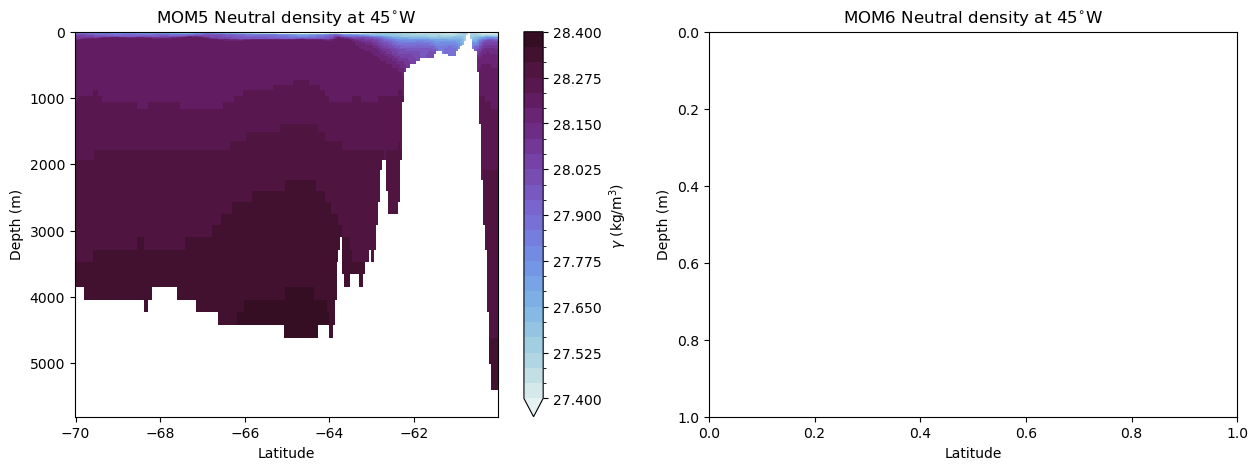

In [42]:
fig, axs = plt.subplots(1, 2, figsize = (15, 5))
gamma_mom5.cf.mean('time').cf.sel(longitude = -45, method = 'nearest').plot.pcolormesh(ax=axs[0], cmap=cmocean.cm.dense,
                                                                                       vmin = 27.4, vmax = 28.4, levels = 25,
                                                                                       cbar_kwargs={'label':'$\\gamma$ (kg/m$^{3}$)'})
#gamma_mom6.cf.mean('time').cf.sel(longitude = -45, method = 'nearest').plot.pcolormesh(ax=axs[1], cmap=cmocean.cm.dense,
#                                                                                       vmin = 27.4, vmax = 28.4,
#                                                                                       cbar_kwargs={'label':'$\\gamma$ (kg/m$^{3}$)'})
for ax in axs:
    ax.invert_yaxis()
    ax.set_ylabel('Depth (m)');
    ax.set_xlabel('Latitude');
axs[0].set_title('MOM5 Neutral density at 45$^{\circ}$W');
axs[1].set_title('MOM6 Neutral density at 45$^{\circ}$W');